# BPPS Units Scheduling Optimization with Python - Data Smoothing

In [ ]:
import pypsa
import pandas as pd
import numpy as np
import gurobipy
##import cplex
from matplotlib import pyplot
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.dates as mdates
import scipy.stats as sp
import seaborn as sns
import time
import openpyxl
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from pylab import rcParams
rcParams['figure.figsize'] = 20, 5

In [ ]:
import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')

path = "./drive/MyDrive/CurrencyProject/Data_COMP5212project.xlsx"


# Import Data

In [ ]:
electricitytimeseries = pd.read_csv('Electric_Production.csv', header=0, index_col=0)

In [ ]:
electricitytimeseries.shape

(96, 1)

In [ ]:
electricitytimeseries.head(96)

,C1
Time,
0,264.00
1,181.50
2,181.50
3,181.50
4,245.15
...,...
91,330.00
92,330.00
93,330.00


# Moving average method

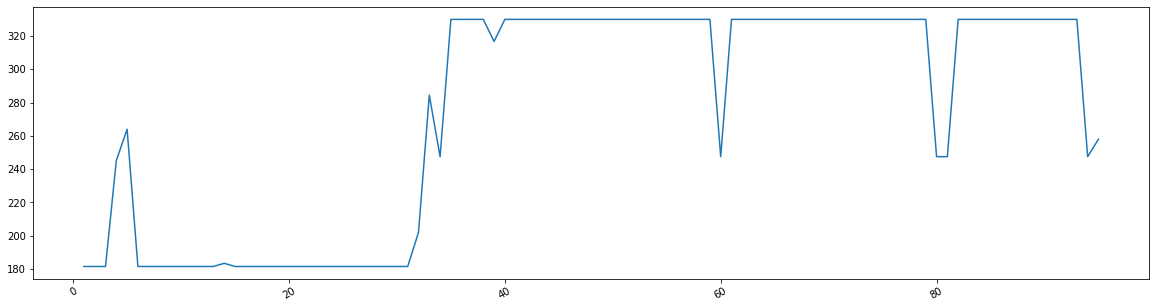

In [ ]:
plt.plot(electricitytimeseries[1:96]['C1'])
plt.xticks(rotation=30)
plt.show()

In [ ]:
#rolling average transform
rollingseries = electricitytimeseries[1:96].rolling(window=3)
rollingmean = rollingseries.mean()
print(rollingmean.head(10))

              C1
Time            
1            NaN
2            NaN
3     181.500000
4     202.716667
5     230.216667
6     230.216667
7     209.000000
8     181.500000
9     181.500000
10    181.500000


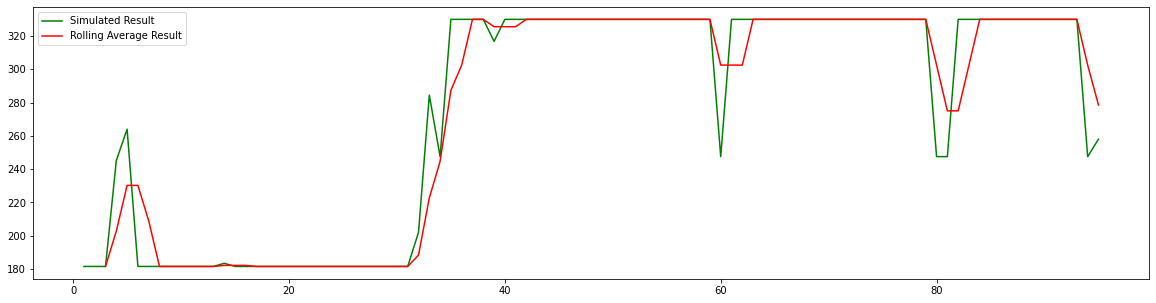

In [ ]:
# plot transformed dataset
plt.plot(electricitytimeseries[1:96]['C1'], color='green', label="Simulated Result")
plt.plot(rollingmean[1:96]['C1'], color='red', label="Rolling Average Result")
plt.legend()
pyplot.show()

## Simple exponential smoothing

In [ ]:
#exponential smoothing-single
data = electricitytimeseries[1:96]
fit1 = SimpleExpSmoothing(data).fit(smoothing_level=0.4,optimized=False)
fit2 = SimpleExpSmoothing(data).fit(smoothing_level=0.8,optimized=False)

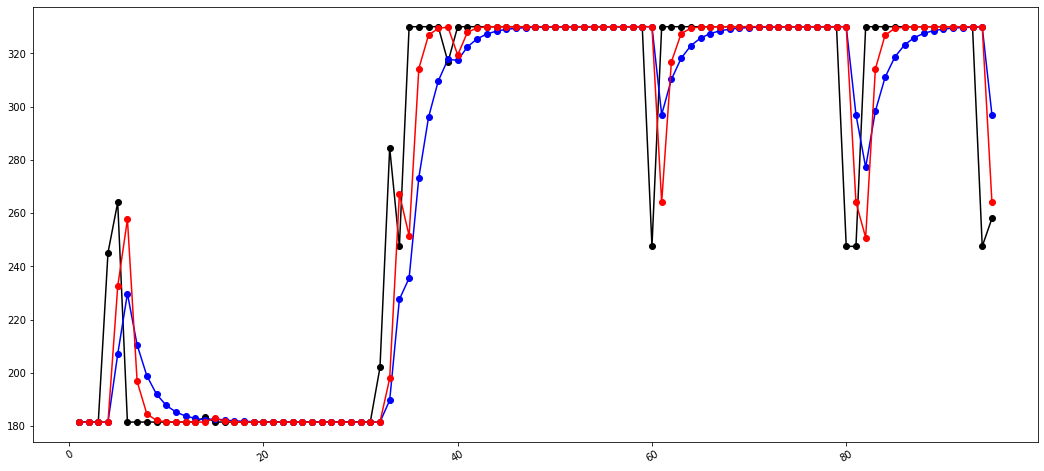

In [ ]:
plt.figure(figsize=(18,8))
plt.plot(electricitytimeseries[1:96], marker='o', color='black')
plt.xticks(rotation=30)
plt.plot(fit1.fittedvalues, marker='o', color='blue')
plt.plot(fit2.fittedvalues, marker='o', color='red')

# Holt Metjhod for exponential smoothing

In [ ]:
fit1 = Holt(data).fit() #linear trend
fit2 = Holt(data, exponential=True).fit()  #exponential trend

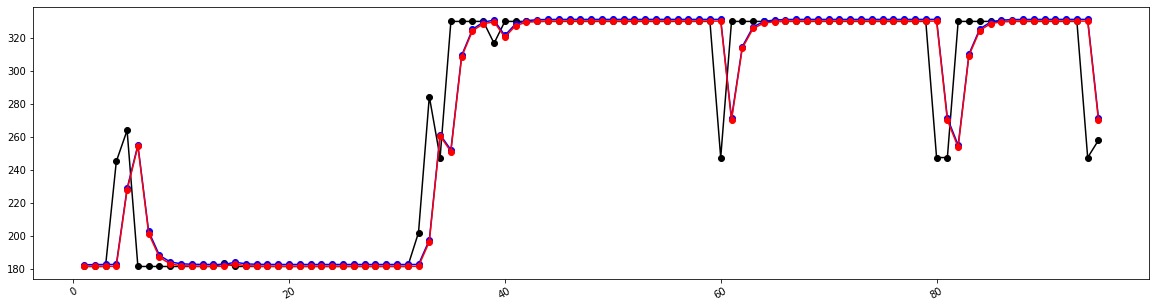

In [ ]:
plt.plot(data, marker='o', color='black')
plt.xticks(rotation=30)
plt.plot(fit1.fittedvalues, marker='o', color='blue')
plt.plot(fit2.fittedvalues, marker='o', color='red')

## Moving Average!!

In [ ]:
data2 = electricitytimeseries[1:96]

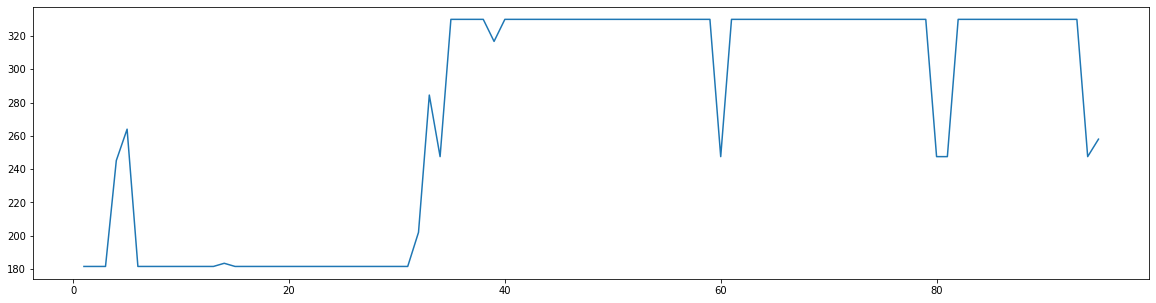

In [ ]:
plt.plot(data2)

In [ ]:
filter_length =4
moving_average = np.convolve(data2['C1'], np.ones((filter_length)), mode='same')
moving_average /=filter_length

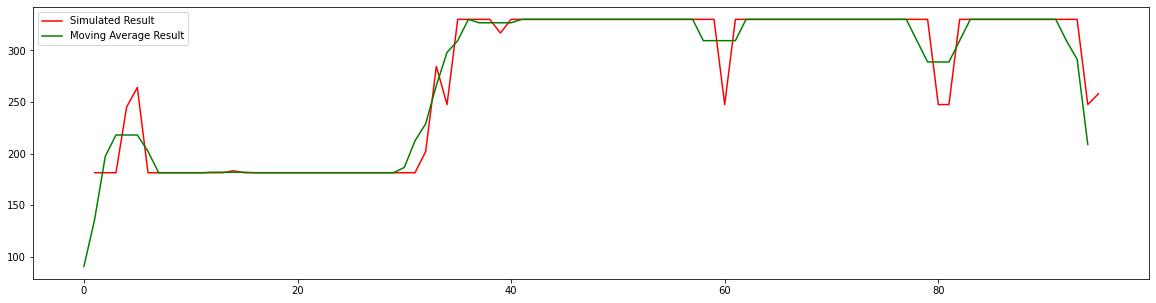

In [ ]:
plt.plot(data2['C1'], color='red', label="Simulated Result")
plt.plot(moving_average, color='green', label="Moving Average Result")
plt.legend()

## Median filter Smoothing!!

In [ ]:
import scipy.signal as signal

In [ ]:
y_med = signal.medfilt(data2['C1'], kernel_size=3)

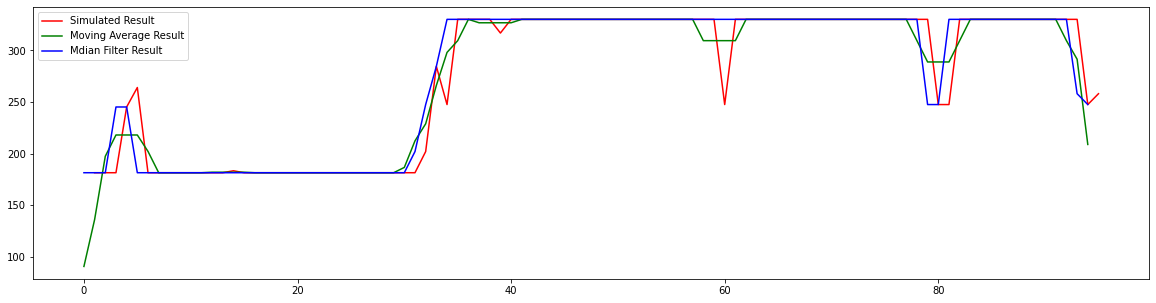

In [ ]:
plt.plot(data2['C1'], color='red', label="Simulated Result")
plt.plot(moving_average, color='green', label="Moving Average Result")
plt.plot(y_med, color='blue', label="Mdian Filter Result")
plt.legend()

## Differencing and seasonal differencing

In [ ]:
#differencing meaning y(t)=y(t)-y(t-1)
data3 = electricitytimeseries[1:96]
data3['#C1_diff'] = data3['C1'] - data3['C1'].shift(1)

<AxesSubplot:xlabel='Time'>

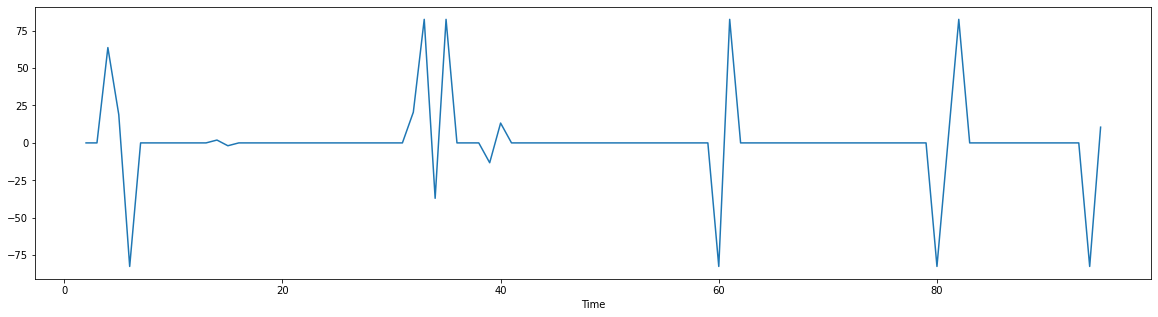

In [ ]:
data3['#C1_diff'].dropna().plot()

# Savitzky-Golay Filter !!

Savitzky-Golay filter is a digital filter that uses data points for smoothing the graph. It uses the method of least squares that creates a small window and applies a polynomial on the data of that window, and then uses that polynomial for assuming the center point of the particular window. Next, the window is shifted by one data point, and the process is iterated until all the neighbors are relatively adjusted with each other.

<function matplotlib.pyplot.show(close=None, block=None)>

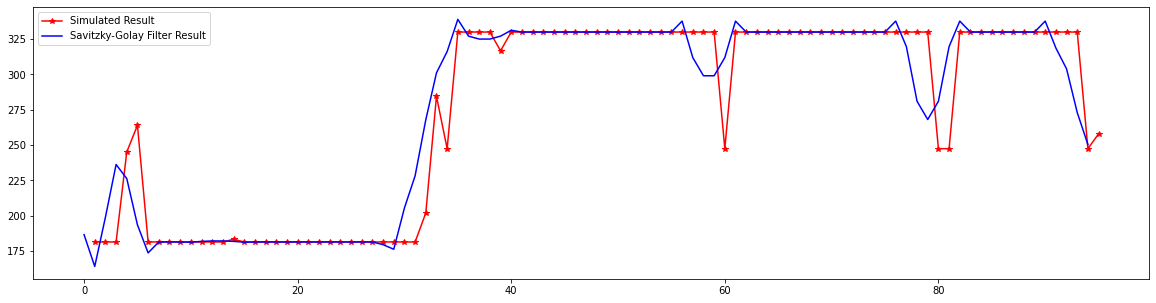

In [ ]:
from scipy.signal import savgol_filter
from matplotlib.widgets import Slider
##savgol_filter(x, window_length, polyorder, deriv=0, delta=1.0, axis=- 1, mode='interp', cval=0.0)
y_filtered = savgol_filter(data['C1'], 6, 3)

fig = plt.figure()
ax = fig.subplots()
p = ax.plot(data['C1'], '-*', color='red', label="Simulated Result")
p = ax.plot(y_filtered, 'g', color='blue', label="Savitzky-Golay Filter Result")
plt.legend()
plt.show

# SciPy to curve fit !!

[2.55423706 1.35190947 0.47450618]
[2.43708906 1.         0.35015434]


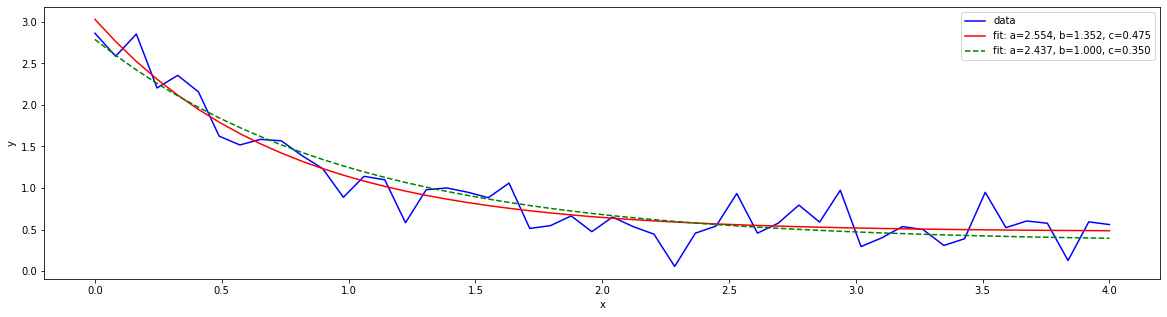

In [ ]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np


# 定义需要拟合的函数
def func(x, a, b, c):
    return a * np.exp(-b * x) + c


# Define the data to be fit with some noise:
# 用numpy的random库生成干扰
xdata = np.linspace(0, 4, 50)
y = func(xdata, 2.5, 1.3, 0.5)
np.random.seed(1729)
y_noise = 0.2 * np.random.normal(size=xdata.size)
ydata = y + y_noise

##xdata = np.linspace(0,2*np.pi,95)
##ydata = electricitytimeseries[1:96]['C1']

plt.plot(xdata, ydata, 'b-', label='data')
# Fit for the parameters a, b, c of the function func:

popt, pcov = curve_fit(func, xdata, ydata)
print(popt)

plt.plot(xdata, func(xdata, *popt), 'r-',
         label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
# Constrain the optimization to the region of 0 <= a <= 3, 0 <= b <= 1 and 0 <= c <= 0.5:
# 限定范围进行拟合
popt, pcov = curve_fit(func, xdata, ydata, bounds=(0, [3., 1., 0.5]))
print(popt)

plt.plot(xdata, func(xdata, *popt), 'g--',
         label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
#结果
#[2.55423706 1.35190947 0.47450618]
#[2.43708905 1.         0.35015434]

# Scipy.signal.savgol_filter()

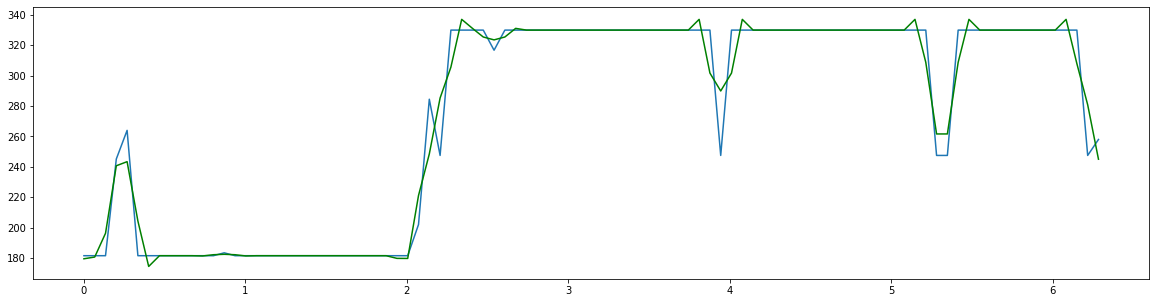

In [ ]:
import numpy as np
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt

x = np.linspace(0,2*np.pi,95)
y = electricitytimeseries[1:96]['C1']

yhat = savgol_filter(y, 5, 2)

plt.plot(x, y)
plt.plot(x,yhat, color='green')
plt.show()

# Numpy.convolve(not considered a good method)

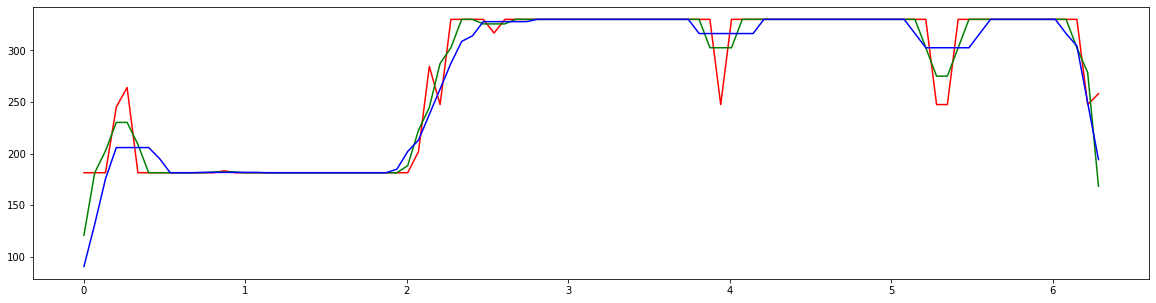

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(0,2*np.pi,95)
y = electricitytimeseries[1:96]['C1']

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

plt.plot(x, y, color='red')
plt.plot(x, smooth(y,3), color='green')
plt.plot(x, smooth(y,6), color='blue')

# Statsmodels.kernel_regression

Kernel Regression computes the conditional mean E[y|X] where y = g(X) + e and fits in the model. It can be used to smooth out data based on the control variable. Note that this method produces a good result but is considered very slow. 

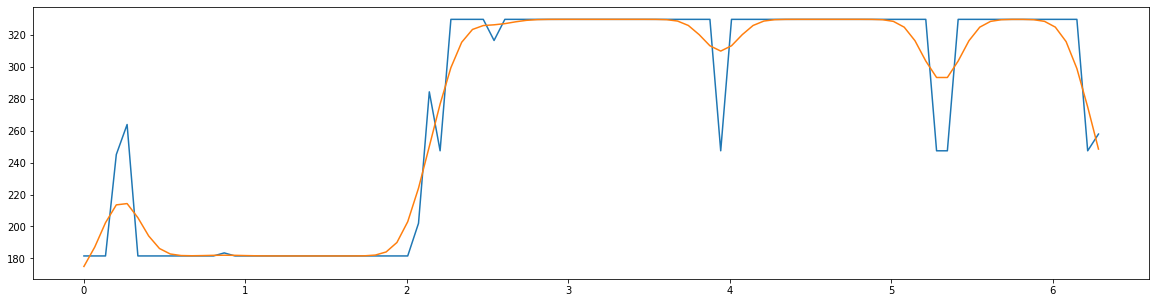

In [ ]:
from statsmodels.nonparametric.kernel_regression import KernelReg
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(0,2*np.pi,95)
y = electricitytimeseries[1:96]['C1']

kr = KernelReg(y,x,'c')
plt.plot(x, y,)
y_pred, y_std = kr.fit(x)

plt.plot(x, y_pred)
plt.show()

# END of programme!!